In [1]:
import os
import glob
import cv2
import time
import copy
import pickle  # Log dictionary data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sn

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # stateless functions
import torchvision.transforms as T
import torchvision.models as models

import multiprocessing
# We must import this explicitly, it is not imported by the top-level
# multiprocessing module.
import multiprocessing.pool

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from datetime import datetime
from multiprocessing import Manager
from PIL import Image

In [19]:
class CFG:
    batch_size = 16
    debug = False
    device = torch.device('cuda')
    dtype = torch.float32
    epochs = 18
    lr = 1e-4
    model_name = 'resnet_head'
    num_classes = 6
    nworkers = 1
    nfolds = 4
    n_tile = 11
    seed = 524
    test_split = 516
    TRAIN = '../yi_data/panda-16x128x128-tiles-data/train/'
    LABELS = '../data/train.csv'

# Split Data

In [3]:
train = pd.read_csv(CFG.LABELS).set_index('image_id')
files = sorted(set([p[:32] for p in os.listdir(CFG.TRAIN)]))
train = train.loc[files].reset_index()

train, test = train_test_split(train, test_size=CFG.test_split, random_state=CFG.seed)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

if CFG.debug:
    df = train.sample(n=50, random_state=CFG.seed).copy()
else:
    df = train.copy()

# Generate train/validation sets containing the same distribution of isup_grade
splits = StratifiedKFold(n_splits=CFG.nfolds, random_state=CFG.seed, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
# Assign split index to training samples
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(CFG.nfolds):
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df.head()

,image_id,data_provider,isup_grade,gleason_score,split
0,89ce8e0a494db9c7ddc68dbf58729c68,radboud,1,3+3,0
1,ef9c72d529806d9ba341476d4c159838,radboud,5,5+4,2
2,139e1e89bca7897799f80da93adcd3c7,karolinska,0,0+0,1
3,0abc61a1bc7abe47b9e44a9f69979eb0,karolinska,2,3+4,3
4,fe7812f20a38495743cf7bf7f811c108,karolinska,1,3+3,1


In [4]:
# https://www.kaggle.com/yasufuminakama/panda-se-resnext50-regression-baseline
class TrainDataset(Dataset):
    """Prostate Cancer Biopsy Dataset"""
    
    def __init__(self, df, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            root_dir (string): Path to the directory with all images
            transform (callable, optional): Optional transform to be applied on an image sample
        """
        # Shuffle dataframes with fixed seed; otherwise, validation set only get cancerous samples
        self.df = df
        self.labels = labels
        self.transform = transform
        #print(len(labels))
        class_counts = [len(labels[labels==g]) for g in range(CFG.num_classes)]
        self.num_samples = sum(class_counts)
        class_weights = [self.num_samples/class_counts[i] for i in range(len(class_counts))]
        self.weights = [class_weights[labels[i]] for i in range(self.num_samples)]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python
        tile_fns = [f"{CFG.TRAIN}/{self.df['image_id'][idx]}_{sub_id}.png" for sub_id in range(CFG.n_tile)]
        img_tiles = [Image.fromarray(cv2.imread(fn)) for fn in tile_fns]
        if self.transform:
            img_tiles = list(map(self.transform, img_tiles))
        
        label = self.labels[idx]
        
        return (img_tiles, label)

In [7]:
train_copy = train.copy().reset_index(drop=True)
print(train_copy.head())

                           image_id data_provider  isup_grade gleason_score
0  89ce8e0a494db9c7ddc68dbf58729c68       radboud           1           3+3
1  ef9c72d529806d9ba341476d4c159838       radboud           5           5+4
2  139e1e89bca7897799f80da93adcd3c7    karolinska           0           0+0
3  0abc61a1bc7abe47b9e44a9f69979eb0    karolinska           2           3+4
4  fe7812f20a38495743cf7bf7f811c108    karolinska           1           3+3


## Transforms

In [5]:
def get_transforms(phase):
    assert phase in {'train', 'val'}
    
    if phase == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(15, fill=255),
            T.ToTensor(),
            T.Normalize( # mean&std based on 11 tiles
                mean=[0.8525, 0.7810, 0.8907],
                std=[0.1723, 0.2614, 0.1419],
            ),
        ])
    else:
        return T.Compose([
            T.ToTensor(),
            T.Normalize(
                mean=[0.8525, 0.7810, 0.8907],
                std=[0.1723, 0.2614, 0.1419],
            ),
        ])

In [17]:
"""
transform = get_transforms(phase='train')
train_dataset = TrainDataset(df.reset_index(drop=True),
                             df.reset_index(drop=True)['isup_grade'],
                             transform = get_transforms(phase='train'))
tiles, label = train_dataset[0]
#tiles = map(transform, tiles)
#print(list(tiles))
#print(label)
#print(tiles.shape)
#print(type(tiles[0]))
plt.imshow(tiles[1].permute(1,2,0))
#plt.show()
#plt.imshow(tiles[0].permute(1,2,0))
"""

"\ntransform = get_transforms(phase='train')\ntrain_dataset = TrainDataset(df.reset_index(drop=True),\n                             df.reset_index(drop=True)['isup_grade'],\n                             transform = get_transforms(phase='train'))\ntiles, label = train_dataset[0]\n#tiles = map(transform, tiles)\n#print(list(tiles))\n#print(label)\n#print(tiles.shape)\n#print(type(tiles[0]))\nplt.imshow(tiles[1].permute(1,2,0))\n#plt.show()\n#plt.imshow(tiles[0].permute(1,2,0))\n"

In [14]:
# Use fold idx as validation set
def data_loader(fold_idx):
    train_idx = df[df['split'] != fold_idx].index
    val_idx = df[df['split'] == fold_idx].index

    train_dataset = TrainDataset(df.loc[train_idx].reset_index(drop=True),
                                 df.loc[train_idx].reset_index(drop=True)['isup_grade'],
                                 transform = get_transforms(phase='train'))
    val_dataset = TrainDataset(df.loc[val_idx].reset_index(drop=True),
                               df.loc[val_idx].reset_index(drop=True)['isup_grade'],
                               transform = get_transforms(phase='val'))
    
    train_sampler = WeightedRandomSampler(weights=train_dataset.weights, num_samples=train_dataset.num_samples)
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, sampler=train_sampler, num_workers=CFG.nworkers)
    val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.nworkers)
    return train_loader, val_loader


def data_loader_test(train_df, test_df):
    train_dataset = TrainDataset(train_df, train_df['isup_grade'],
                                 transform = get_transforms(phase='train'))
    test_dataset = TrainDataset(test_df, test_df['isup_grade'],
                               transform = get_transforms(phase='val'))
    
    train_sampler = WeightedRandomSampler(weights=train_dataset.weights, num_samples=train_dataset.num_samples)
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, sampler=train_sampler, num_workers=CFG.nworkers)
    test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.nworkers)
    return train_loader, test_loader

In [36]:
def train_model(model, fold, dataloaders, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    
    # Send the model to GPU/CPU
    model = model.to(device=CFG.device)
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training phase
            else:
                # Skip evaluation for test dataset except for the last epoch
                if (len(dataloaders[phase].dataset) != CFG.test_split) or (num_epochs == epoch+1):
                    model.eval()    # Set model to evaluate phase
                else:
                    continue
            
            avg_loss = 0.0
            running_corrects = 0
            
            print(' ', end='', flush=True)  # To workaround tqdm issue in multiprocess
            for inputs, labels in tqdm(dataloaders[phase],
                                       desc='[{}] {}/{}({:5s})'.format(fold, epoch+1,num_epochs,phase)):
                _, C, H, W = inputs[0].shape
                # n_tile[(bs,3,128,128)]-->(bs,n_tile,3,128,128)-->(bs*n_tile,3,128,128)
                inputs = torch.stack(inputs, 1).view(-1,C,H,W).to(device=CFG.device, dtype=CFG.dtype)
                labels = labels.to(device=CFG.device, dtype=torch.long)
                #print(labels)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward, track history if only in training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    pred = torch.argmax(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                input_sz = inputs[0].shape[0]
                avg_loss += loss.item()*(input_sz/len(dataloaders[phase].dataset))  # len(dataloaders[phase].dataset) not len(dataloaders[phase])
                running_corrects += torch.sum(pred == labels)
            
            # End of epoch
            with torch.no_grad():
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                if phase == 'val':
                    val_acc_history.append(epoch_acc)
                    # deep copy the model
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                    # Apply lr_scheduler
                    if scheduler is not None:
                        scheduler.step(avg_loss)
                else:
                    train_acc_history.append(epoch_acc)
                    loss_history.append(avg_loss)
                print('[{}] {} Loss: {:4f} Acc: {:4f}'.format(fold, phase, avg_loss, epoch_acc))
    
    time_elapsed = time.time() - since
    print('[{}] Training complete in {:.0f}m {:0f}s'.format(fold, time_elapsed//60, time_elapsed%60))
    print('[{}] Best val Acc: {:4f}'.format(fold, best_acc))
    print()
    
    model.load_state_dict(best_model_wts)
                      
    return model, loss_history, train_acc_history, val_acc_history

## Layer Utils

In [10]:
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=1):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        self.output_size = sz
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

# https://www.kaggle.com/nelsongriffiths/mish-activation-and-transfer-learning-pytorch
def mish(x):
    return (x*torch.tanh(F.softplus(x)))

class mish_layer(nn.Module):
    def __init__(self):
        super(mish_layer, self).__init__()
        
    def forward(self, input):
        return mish(input)
    
class CustomResnet(nn.Module):
    def __init__(self, n=6):
        super().__init__()
        self.enc = nn.Sequential(*list(models.resnet18(pretrained=False).children())[:-2])
        num_ftrs= models.resnet18().fc.in_features
        self.head = nn.Sequential(
                        AdaptiveConcatPool2d(),
                        nn.Flatten(),
                        nn.Linear(num_ftrs*2,512),
                        mish_layer(),
                        nn.BatchNorm1d(512),
                        nn.Dropout(0.5),
                        nn.Linear(512, n)
                    )
        
    def forward(self, x):
        n_tile = CFG.n_tile
        enc_out = self.enc(x)
        _, C, H, W = enc_out.shape
        # (bs,n_tile,512,4,4)-->(bs,512,n_tile,4,4)-->(bs,512,n_tile*4,4)
        head_in = enc_out.view(-1,n_tile,C,H,W).permute(0,2,1,3,4)\
                  .contiguous().view(-1,C,n_tile*H,W)
        head_out = self.head(head_in)
        
        return head_out

In [16]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False):
    """
    Params:
        feature_extract
            True - fine tunning
            False - fix the model
    """
    model_ft = None
    
    if model_name == 'alexnet':
        """AlexNet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet':
        """Resnet
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet_head':
        """Restnet with customized header
        """
        model_ft = CustomResnet(num_classes)
    
    return model_ft

In [22]:
"""
model_ft = initialize_model(CFG.model_name, CFG.num_classes, use_pretrained=False)
train_loader, _ = data_loader(0)
for tiles, _ in train_loader:
    print(tiles[0].shape)
    #plt.imshow(tiles[0].squeeze().permute(1,2,0))
    conv_out = model_ft(tiles)
    print(conv_out.shape)
    break
"""

'\nmodel_ft = initialize_model(CFG.model_name, CFG.num_classes, use_pretrained=False)\ntrain_loader, _ = data_loader(0)\nfor tiles, _ in train_loader:\n    print(tiles[0].shape)\n    #plt.imshow(tiles[0].squeeze().permute(1,2,0))\n    conv_out = model_ft(tiles)\n    print(conv_out.shape)\n    break\n'

In [23]:
"""Multiprocessing
"""
class NoDaemonProcess(multiprocessing.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class MyPool(multiprocessing.pool.Pool):
    Process = NoDaemonProcess

def train_fn(fold):
    model_ft = initialize_model(CFG.model_name, CFG.num_classes)
    """
    optimizer = optim.SGD(model_ft.parameters(),
                          lr=CFG.lr,
                          momentum=.9,
                          nesterov=True)
    """
    optimizer = optim.Adam(model_ft.parameters(),
                           lr=CFG.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, eps=1e-06)
    #print(f'### FOLD: {fold} ###', flush=True)
    loader_train, loader_val = data_loader(fold)
    best_model, loss_history, train_acc_history, val_acc_history = train_model(model_ft, fold, {'train': loader_train, 'val': loader_val}, F.cross_entropy, optimizer, scheduler, CFG.epochs)

    return best_model, loss_history, train_acc_history, val_acc_history

def progressor(fold):
    best_model, loss_history, train_acc_history, val_acc_history = train_fn(fold)
    return {f'best_model_{fold}': best_model.to('cpu'),  # Don't save model as cuda
            f'loss_history_{fold}': loss_history,
            f'train_acc_history_{fold}': train_acc_history,
            f'val_acc_history_{fold}': val_acc_history}

## Resnet18
log: resnet_head_05_31_2020_00_08.pkl

In [24]:
log_dict = {'batch_size': CFG.batch_size,
            'epochs': CFG.epochs,
            'learning_rate': CFG.lr,
            'model': CFG.model_name,
            'nworkers': CFG.nworkers,
            'nfolds': CFG.nfolds,
            'random_seed': CFG.seed}

nfold = range(CFG.nfolds)
#nfold_left = range(CFG.nfolds//2)
#nfold_right = range(CFG.nfolds//2, CFG.nfolds)
#print(nfold_left)
#print(nfold_right)
#result_list = []
result_list = list(MyPool(CFG.nfolds).map(progressor, nfold))
#result_list.append(list(MyPool(CFG.nfolds).map(progressor, nfold_left)))
#result_list.append(list(MyPool(CFG.nfolds).map(progressor, nfold_right)))
#progressor(0)

# Accumulate result from each process
for result in result_list:
    log_dict.update(result)

# Log results
log_file = f'{CFG.model_name}_{datetime.now().strftime("%m_%d_%Y_%H_%M")}.pkl'
with open(log_file, 'wb') as pkl_file:
    pickle.dump(log_dict, pkl_file)


[2] train Loss: 0.344152 Acc: 0.238133
 


[2] val Loss: 0.308965 Acc: 0.318000
 


[3] train Loss: 0.342603 Acc: 0.243200
 


[1] train Loss: 0.343979 Acc: 0.243067
 


[0] train Loss: 0.342582 Acc: 0.239200
 


[3] val Loss: 0.307768 Acc: 0.327600
 


[1] val Loss: 0.325012 Acc: 0.309600
 


[0] val Loss: 0.292661 Acc: 0.358800
 


[2] train Loss: 0.323160 Acc: 0.290800
 


[2] val Loss: 0.297959 Acc: 0.353200
 


[3] train Loss: 0.322728 Acc: 0.292133
 


[1] train Loss: 0.321703 Acc: 0.297067
 


[0] train Loss: 0.324764 Acc: 0.283600
 


[3] val Loss: 0.286392 Acc: 0.360800
 


[1] val Loss: 0.292174 Acc: 0.366400
 


[0] val Loss: 0.278261 Acc: 0.414800
 


[2] train Loss: 0.306062 Acc: 0.321067
 


[2] val Loss: 0.287209 Acc: 0.363600
 


[3] train Loss: 0.306766 Acc: 0.325200
 


[1] train Loss: 0.306917 Acc: 0.319067
 


[0] train Loss: 0.310118 Acc: 0.317467
 


[3] val Loss: 0.274761 Acc: 0.410800
 


[1] val Loss: 0.273613 Acc: 0.404400
 


[0] val Loss: 0.270385 Acc: 0.402400
 


[2] train Loss: 0.297821 Acc: 0.345200
 


[2] val Loss: 0.273692 Acc: 0.403600
 


[3] train Loss: 0.299315 Acc: 0.345200
 


[1] train Loss: 0.296690 Acc: 0.342133
 


[0] train Loss: 0.296733 Acc: 0.349067
 


[3] val Loss: 0.283306 Acc: 0.418800
 


[1] val Loss: 0.278625 Acc: 0.399200
 


[0] val Loss: 0.289539 Acc: 0.386800
 


[2] train Loss: 0.290296 Acc: 0.362400
 


[2] val Loss: 0.282498 Acc: 0.381200
 


[3] train Loss: 0.289993 Acc: 0.363200
 


[1] train Loss: 0.288290 Acc: 0.356400
 


[0] train Loss: 0.294960 Acc: 0.343733
 


[1] val Loss: 0.293515 Acc: 0.390400
 


[3] val Loss: 0.269813 Acc: 0.400000
 


[0] val Loss: 0.269180 Acc: 0.424400
 


[2] train Loss: 0.292207 Acc: 0.357467
 


[2] val Loss: 0.270231 Acc: 0.420400
 


[1] train Loss: 0.284135 Acc: 0.377200
 


[3] train Loss: 0.284987 Acc: 0.363333
 


[0] train Loss: 0.286954 Acc: 0.369600
 


[1] val Loss: 0.264031 Acc: 0.437600
 


[3] val Loss: 0.345760 Acc: 0.270000
 


[0] val Loss: 0.266117 Acc: 0.429600
 


[2] train Loss: 0.283253 Acc: 0.371867
 


[2] val Loss: 0.257330 Acc: 0.458400
 


[1] train Loss: 0.280177 Acc: 0.386933
 


[3] train Loss: 0.281453 Acc: 0.386800
 


[0] train Loss: 0.276174 Acc: 0.388000
 


[3] val Loss: 0.360978 Acc: 0.297600
 


[1] val Loss: 0.269567 Acc: 0.438400
 


[0] val Loss: 0.345522 Acc: 0.270800
 


[2] train Loss: 0.278797 Acc: 0.383333
 


[2] val Loss: 0.352247 Acc: 0.289600
 


[3] train Loss: 0.277044 Acc: 0.388000
 


[1] train Loss: 0.278670 Acc: 0.386133
 


[0] train Loss: 0.277086 Acc: 0.387600
 


[3] val Loss: 0.267974 Acc: 0.429200
 


[1] val Loss: 0.255352 Acc: 0.435600
 


[0] val Loss: 0.258803 Acc: 0.447200
 


[2] train Loss: 0.276620 Acc: 0.390133
 


[2] val Loss: 0.325357 Acc: 0.332400
 


[3] train Loss: 0.272833 Acc: 0.400267
 


[1] train Loss: 0.272113 Acc: 0.402533
 


[0] train Loss: 0.274335 Acc: 0.397067
 


[3] val Loss: 0.256793 Acc: 0.467200
 


[1] val Loss: 0.274930 Acc: 0.396800
 


[0] val Loss: 0.252059 Acc: 0.459600
 


[2] train Loss: 0.275676 Acc: 0.396267
 


Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
[2] val Loss: 0.310598 Acc: 0.368000
 


[2] train Loss: 0.260911 Acc: 0.427333
 


[3] train Loss: 0.273353 Acc: 0.403333
 


[1] train Loss: 0.270858 Acc: 0.413467
 


[0] train Loss: 0.268994 Acc: 0.406533
 


[1] val Loss: 0.256475 Acc: 0.440000
 


[3] val Loss: 0.281681 Acc: 0.423600
 


[2] val Loss: 0.242945 Acc: 0.490000
 


[0] val Loss: 0.267382 Acc: 0.439600
 


[2] train Loss: 0.259702 Acc: 0.438533
 


[1] train Loss: 0.267257 Acc: 0.423067
 


[2] val Loss: 0.256534 Acc: 0.468000
 


[3] train Loss: 0.268484 Acc: 0.414267
 


[0] train Loss: 0.267721 Acc: 0.416400
 


[1] val Loss: 0.250794 Acc: 0.458400
 


[3] val Loss: 0.323844 Acc: 0.385200
 


[0] val Loss: 0.263361 Acc: 0.441600
 


[2] train Loss: 0.260256 Acc: 0.438133
 


[2] val Loss: 0.247463 Acc: 0.480000
 


[1] train Loss: 0.261128 Acc: 0.429067
 


[3] train Loss: 0.263767 Acc: 0.430533
 


[0] train Loss: 0.268084 Acc: 0.414000
 


[1] val Loss: 0.255914 Acc: 0.450000
 


Epoch    12: reducing learning rate of group 0 to 1.0000e-05.
[3] val Loss: 0.327422 Acc: 0.368800
 


Epoch    12: reducing learning rate of group 0 to 1.0000e-05.
[0] val Loss: 0.260277 Acc: 0.446400
 


[2] train Loss: 0.254477 Acc: 0.447733
 


Epoch    14: reducing learning rate of group 0 to 1.0000e-06.
[2] val Loss: 0.242967 Acc: 0.485200
 


[1] train Loss: 0.257804 Acc: 0.440133
 


[3] train Loss: 0.253956 Acc: 0.452000
 


[0] train Loss: 0.254847 Acc: 0.444000
 


[1] val Loss: 0.268106 Acc: 0.432400
 


[3] val Loss: 0.243446 Acc: 0.472800
 


[0] val Loss: 0.239815 Acc: 0.490000
 


[2] train Loss: 0.256544 Acc: 0.449067
 


[2] val Loss: 0.243209 Acc: 0.488000
 


[1] train Loss: 0.257907 Acc: 0.440133
 


[3] train Loss: 0.247972 Acc: 0.465200
 


[0] train Loss: 0.249194 Acc: 0.463867
 


Epoch    14: reducing learning rate of group 0 to 1.0000e-05.
[1] val Loss: 0.259095 Acc: 0.446800
 


[3] val Loss: 0.243808 Acc: 0.479200
 


[0] val Loss: 0.237669 Acc: 0.496400
 


[2] train Loss: 0.252653 Acc: 0.455067
 


[2] val Loss: 0.246398 Acc: 0.484800
 


[1] train Loss: 0.251318 Acc: 0.460933
 


[3] train Loss: 0.247743 Acc: 0.469600
 


[0] train Loss: 0.248442 Acc: 0.460400
 


[1] val Loss: 0.239464 Acc: 0.483600
 


[3] val Loss: 0.238814 Acc: 0.494800
 


[0] val Loss: 0.237993 Acc: 0.495600
 


[2] train Loss: 0.251627 Acc: 0.456667
 


[2] val Loss: 0.238878 Acc: 0.495600
 


[1] train Loss: 0.244712 Acc: 0.475067
 


[3] train Loss: 0.245210 Acc: 0.476400
 


[0] train Loss: 0.243083 Acc: 0.474800
 


[1] val Loss: 0.239099 Acc: 0.484000
 


[3] val Loss: 0.240954 Acc: 0.481600
 


[0] val Loss: 0.240261 Acc: 0.484800
 


[2] train Loss: 0.250922 Acc: 0.464133
 


[2] val Loss: 0.239021 Acc: 0.495600
[2] Training complete in 372m 42.368662s
[2] Best val Acc: 0.495600


[1] train Loss: 0.241794 Acc: 0.490133
 


[3] train Loss: 0.244561 Acc: 0.472533
 


[0] train Loss: 0.242301 Acc: 0.481333
 


[1] val Loss: 0.235646 Acc: 0.499600
 


[3] val Loss: 0.238954 Acc: 0.488000
 


Epoch    17: reducing learning rate of group 0 to 1.0000e-06.
[0] val Loss: 0.239031 Acc: 0.496000
 


[1] train Loss: 0.240854 Acc: 0.492000
 


[3] train Loss: 0.243523 Acc: 0.470933
 


[0] train Loss: 0.241244 Acc: 0.479333
 


[1] val Loss: 0.239629 Acc: 0.484400
[1] Training complete in 399m 30.710142s
[1] Best val Acc: 0.499600


Epoch    18: reducing learning rate of group 0 to 1.0000e-06.
[3] val Loss: 0.241359 Acc: 0.489600
[3] Training complete in 399m 37.565614s
[3] Best val Acc: 0.494800


[0] val Loss: 0.234347 Acc: 0.502800
[0] Training complete in 399m 42.706435s
[0] Best val Acc: 0.502800



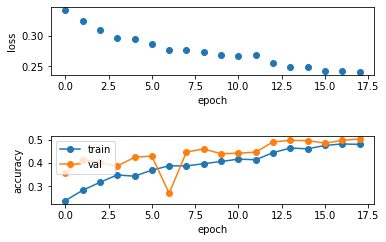

In [11]:
# read python dict back from the file
#with open(log_file, 'rb') as pfile:
with open('resnet_head_06_02_2020_13_40.pkl', 'rb') as pfile:
    log_dict = pickle.load(pfile)
#test_dict = log_dict

"""
Graphs
1. loss vs. iterations
2. Train/Validation accuracy along epoch
"""
plt.subplot(2,1,1)
plt.plot(log_dict['loss_history_0'], 'o')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(log_dict['train_acc_history_0'], '-o')
plt.plot(log_dict['val_acc_history_0'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.tight_layout(pad=3)
plt.show()

In [12]:
preds, targets = [], []
for fold in range(CFG.nfolds):
    #model_fd = test_dict[f'best_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    model_fd = log_dict[f'best_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    _, loader_val = data_loader(fold)
    for inputs, labels in tqdm(loader_val):
        _, C, H, W = inputs[0].shape
        # n_tile[(bs,3,128,128)]-->(bs,n_tile,3,128,128)-->(bs*n_tile,3,128,128)
        inputs = torch.stack(inputs, 1).view(-1,C,H,W).to(device=CFG.device, dtype=CFG.dtype)
        labels = labels.to(device=CFG.device, dtype=torch.long)
                
        # Forward, track history if only in training
        with torch.no_grad():
            outputs = model_fd(inputs)
            pred = torch.argmax(outputs, 1)
        preds.append(pred)
        targets.append(labels)

Kappa: 0.6580674281048344


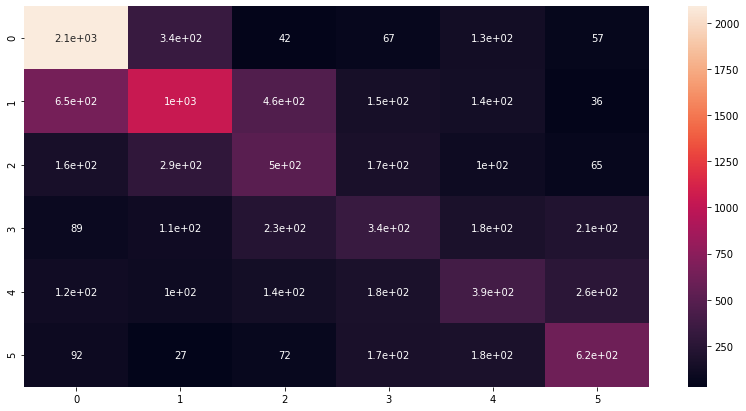

In [13]:
p = torch.cat(preds).cpu()
t = torch.cat(targets).cpu()
kappa = cohen_kappa_score(t, p, weights='quadratic')
print(f'Kappa: {kappa}')
conf_mat = confusion_matrix(t,p)
#plt.matshow()
plt.figure(figsize=(14,7))
sn.heatmap(conf_mat, annot=True)

# Test Results

In [37]:
def train_full(train_df, test_df):
    model_ft = initialize_model(CFG.model_name, CFG.num_classes)
    optimizer = optim.Adam(model_ft.parameters(),
                           lr=CFG.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, eps=1e-06)
    
    loader_train, loader_test = data_loader_test(train_df, test_df)
    best_model, loss_history, train_acc_history, val_acc_history = train_model(model_ft, fold, {'train': loader_train, 'val': loader_test}, F.cross_entropy, optimizer, scheduler, CFG.epochs+5)

    return best_model, loss_history, train_acc_history, val_acc_history
          

best_model, loss_history, train_acc_history, test_acc_history = train_full(train, test)


[3] train Loss: 0.338596 Acc: 0.256900
 


[3] train Loss: 0.316185 Acc: 0.296800
 


[3] train Loss: 0.301377 Acc: 0.333300
 


[3] train Loss: 0.289981 Acc: 0.364000
 


[3] train Loss: 0.283936 Acc: 0.360900
 


[3] train Loss: 0.279550 Acc: 0.388000
 


[3] train Loss: 0.276094 Acc: 0.391500
 


[3] train Loss: 0.271352 Acc: 0.399600
 


[3] train Loss: 0.267654 Acc: 0.419300
 


[3] train Loss: 0.267493 Acc: 0.409800
 


[3] train Loss: 0.262719 Acc: 0.431300
 


[3] train Loss: 0.261646 Acc: 0.425500
 


[3] train Loss: 0.260926 Acc: 0.433700
 


[3] train Loss: 0.254489 Acc: 0.449700
 


[3] train Loss: 0.255170 Acc: 0.447700
 


[3] train Loss: 0.244880 Acc: 0.473800
 


[3] train Loss: 0.244685 Acc: 0.479200
 


[3] train Loss: 0.241530 Acc: 0.491600
 


[3] train Loss: 0.237020 Acc: 0.494100
 


[3] train Loss: 0.233266 Acc: 0.507000
 


[3] train Loss: 0.228664 Acc: 0.516800
 


[3] train Loss: 0.228096 Acc: 0.522900
 


[3] train Loss: 0.223000 Acc: 0.532300
 


[3] val Loss: 0.268147 Acc: 0.461240
[3] Training complete in 173m 44.852720s
[3] Best val Acc: 0.461240



In [41]:
test_dict = {'batch_size': CFG.batch_size,
             'epochs': CFG.epochs,
             'learning_rate': CFG.lr,
             'model': CFG.model_name,
             'nworkers': CFG.nworkers,
             'nfolds': CFG.nfolds,
             'random_seed': CFG.seed,
             'best_model_test': best_model.to('cpu'),  # Don't save model as cuda
             'loss_history_test': loss_history,
             'train_acc_history_test': train_acc_history,
             'val_acc_history_test': test_acc_history}


# Log results
log_file = f'{CFG.model_name}_test_{datetime.now().strftime("%m_%d_%Y_%H_%M")}.pkl'
with open(log_file, 'wb') as pkl_file:
    pickle.dump(log_dict, pkl_file)

In [39]:
# resnet_head_test_06_02_2020_20_55.pkl
preds_test, targets_test = [], []
_, loader_test = data_loader_test(train, test)
for inputs, labels in tqdm(loader_test):
    _, C, H, W = inputs[0].shape
    # n_tile[(bs,3,128,128)]-->(bs,n_tile,3,128,128)-->(bs*n_tile,3,128,128)
    inputs = torch.stack(inputs, 1).view(-1,C,H,W).to(device=CFG.device, dtype=CFG.dtype)
    labels = labels.to(device=CFG.device, dtype=torch.long)

    # Forward, track history if only in training
    with torch.no_grad():
        outputs = best_model(inputs)
        pred = torch.argmax(outputs, 1)
    preds_test.append(pred)
    targets_test.append(labels)

Kappa: 0.6326865728786015


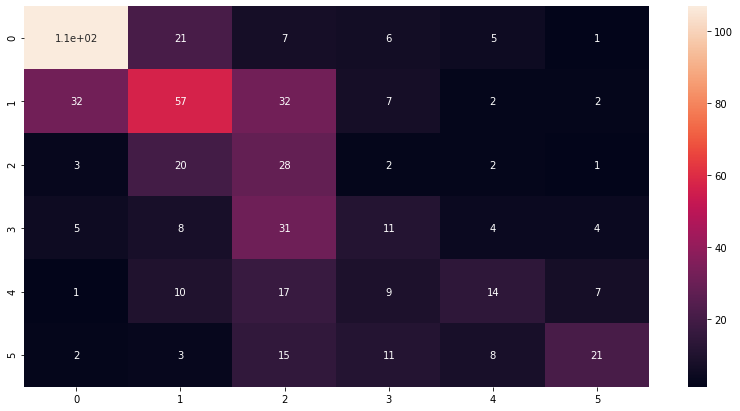

In [40]:
p_test = torch.cat(preds_test).cpu()
t_test = torch.cat(targets_test).cpu()
kappa = cohen_kappa_score(t_test, p_test, weights='quadratic')
print(f'Kappa: {kappa}')
conf_mat = confusion_matrix(t_test,p_test)
#plt.matshow()
plt.figure(figsize=(14,7))
sn.heatmap(conf_mat, annot=True)